In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import joblib

data = pd.read_csv("test.csv")
print(data.shape)
data.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [2]:
data.drop("Id", axis=1, inplace=True)
data.shape

(1459, 79)

In [3]:
data['MSSubClass'] = data['MSSubClass'].astype('O')

In [4]:
with_string_missing = ['Alley', 'FireplaceQu',
                       'PoolQC', 'Fence', 'MiscFeature']

with_frequent_category = {
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': 'SBrkr',
    'GarageType': 'Attchd',
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',
}

In [5]:
data[with_string_missing] = data[with_string_missing].fillna('Missing')

In [6]:
for var in with_frequent_category.keys():
    data[var].fillna(with_frequent_category[var], inplace=True)

/var/folders/t4/_q_4t1vj77s3lm4cmk06hnym0000gr/T/ipykernel_28894/3277757948.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[var].fillna(with_frequent_category[var], inplace=True)


In [7]:
vars_with_na = {
    'LotFrontage': 69.87974098057354,
    'MasVnrArea': 103.7974006116208,
    'GarageYrBlt': 1978.2959677419356,
}

In [8]:
for var in vars_with_na.keys():
    data[var + '_na'] = np.where(data[var].isnull(), 1, 0)
    data[var].fillna(vars_with_na[var], inplace=True)

data[list(vars_with_na.keys())].isnull().sum()

/var/folders/t4/_q_4t1vj77s3lm4cmk06hnym0000gr/T/ipykernel_28894/1539811722.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[var].fillna(vars_with_na[var], inplace=True)
/var/folders/t4/_q_4t1vj77s3lm4cmk06hnym0000gr/T/ipykernel_28894/1539811722.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [9]:
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

In [10]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

In [11]:
data.drop(['YrSold'], axis=1, inplace=True)

In [12]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    data[var] = np.log(data[var])

In [13]:
data['LotArea'] = stats.yeojohnson(data['LotArea'], lmbda=-12.55283001172003)

In [14]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed:
    data[var] = np.where(data[var]==0, 0, 1)

In [15]:
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    data[var] = data[var].map(qual_mappings)

In [16]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

data[var] = data[var].map(exposure_mappings)

In [17]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    data[var] = data[var].map(finish_mappings)

In [18]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

data[var] = data[var].map(garage_mappings)

In [19]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

data[var] = data[var].map(fence_mappings)

In [20]:
with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

with_null

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea',
 'SaleType']

In [21]:
[var for var in with_null if var in list(
    with_frequent_category.keys())+with_string_missing+list(vars_with_na.keys())]

[]

In [22]:
frequent_ls = {
    'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
    'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
                     'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
                     'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
                     'Somerst', 'StoneBr', 'Timber'],

    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],

    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],

    'MasVnrType': ['BrkFace', 'None', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['Missing'],
    'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
}

In [23]:
for var in frequent_ls.keys():
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

In [24]:
ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                     'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                     'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                     'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                     'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
    
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,
                   '70': 7, '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
}

In [25]:
for var in ordinal_mappings.keys():
    ordinal_label = ordinal_mappings[var]
    data[var] = data[var].map(ordinal_label)

In [26]:
with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

len(with_null)

13

In [27]:
data.fillna(0, inplace=True)

In [28]:
scaler = joblib.load('minmax_scaler.joblib') 

data = pd.DataFrame(
    scaler.transform(data),
    columns=data.columns
)

In [29]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.083333,0.0,0.495064,-1.246003,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.75,0.0,0.000000,0.454545,0.333333,0.0,0.0,0.0,0.0
1,0.083333,0.0,0.499662,-1.246003,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,0.000065,0.454545,0.333333,0.0,0.0,0.0,0.0
2,0.083333,0.0,0.466207,-1.246003,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.75,0.0,0.000000,0.181818,0.333333,0.0,0.0,0.0,0.0
3,0.083333,0.0,0.485693,-1.246003,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,0.000000,0.454545,0.333333,0.0,0.0,0.0,0.0
4,0.083333,0.0,0.265271,-1.246003,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,0.000000,0.000000,0.333333,0.0,0.0,0.0,0.0


In [30]:
features = pd.read_csv('selected_features.csv')
features = features['0'].to_list() 

data = data[features]

data.shape

(1459, 36)

<Axes: >

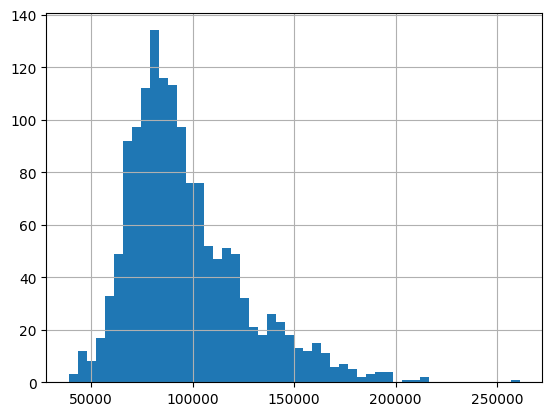

In [31]:
lin_model = joblib.load('linear_regression.joblib') 

pred = lin_model.predict(data)

pd.Series(np.exp(pred)).hist(bins=50)